In [1]:
import numpy as np
from sklearn import preprocessing
import random
import math
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_olivetti_faces
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier




dataset = fetch_olivetti_faces(shuffle=True, random_state=42)

total_images, h, w = dataset.images.shape  # Total images = 400, h=64, w=64.
X = dataset.data
y = dataset.target
 
# Splitting the dataset into training and test(By default 75% is training and 25% is test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)  # Since test size is 0.1, 10% images are used as test images.

In [3]:
shape=(h,w)  #64*64
def pca(X_train):
  V = np.resize(X_train, (total_images, shape[0]*shape[1])) #We first convert the N*N images into 400 face vectors of size 1*N^2. Here N=64. Size of V = 400*N^2
  mean_V = np.sum(V, axis=0, dtype='float64')/total_images #Now we calculate the average of all these face vectors in V.
  mean_matrix = np.tile(mean_V, (total_images, 1)) #Now we make 400 duplicates of the mean vector to get a 400*image_vector_size matrix.
  V_1 = V - mean_matrix #Subtracting average of face vectors from each vector.
  Cov_sort_of = (V_1.dot(V_1.T))/total_images # It won't change the eigenvalues and eigenvectors if we take it to be (V_1.T)dotV_1. The difference will be only in computational efficiency.
  eigenvalues, eigenvectors = np.linalg.eig(Cov_sort_of)  #find the eigenvalues and the eigenvectors of Cov_sort_of.
  indices = eigenvalues.argsort()[::-1]  #get the indices of the eigenvalues by its value. Descending order.
  eigenvalues = eigenvalues[indices] 
  eigenvectors = eigenvectors[:, indices] #Now we have got the eigenvalues and eigenvectors in descending order
  eigenvectors_C = V_1.T @ eigenvectors #linear combination of each column of V_1

  eigenvectors_C.shape 
  #each column is an eigenvector of C where C = (V_1.T)(V_1).
  
  #Now we normalize the eigenvectors.
  eigenfaces = preprocessing.normalize((eigenvectors_C.T).real) #normalize only accepts matrix with n_samples, n_feature. Hence we need to take the transpose. The size of eigenfaces matrix will be 400*N^2, where N=64.
  return eigenfaces,mean_V

  

In [4]:
eigenfaces,mean_face=pca(X_train)

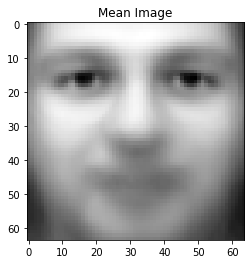

In [5]:
plt.imshow(np.resize(mean_face, (shape[0],shape[1])), cmap='gray') #Plot the mean image resized to 64*64.
plt.title('Mean Image')
plt.show()

## Get the top K eigenfaces. 


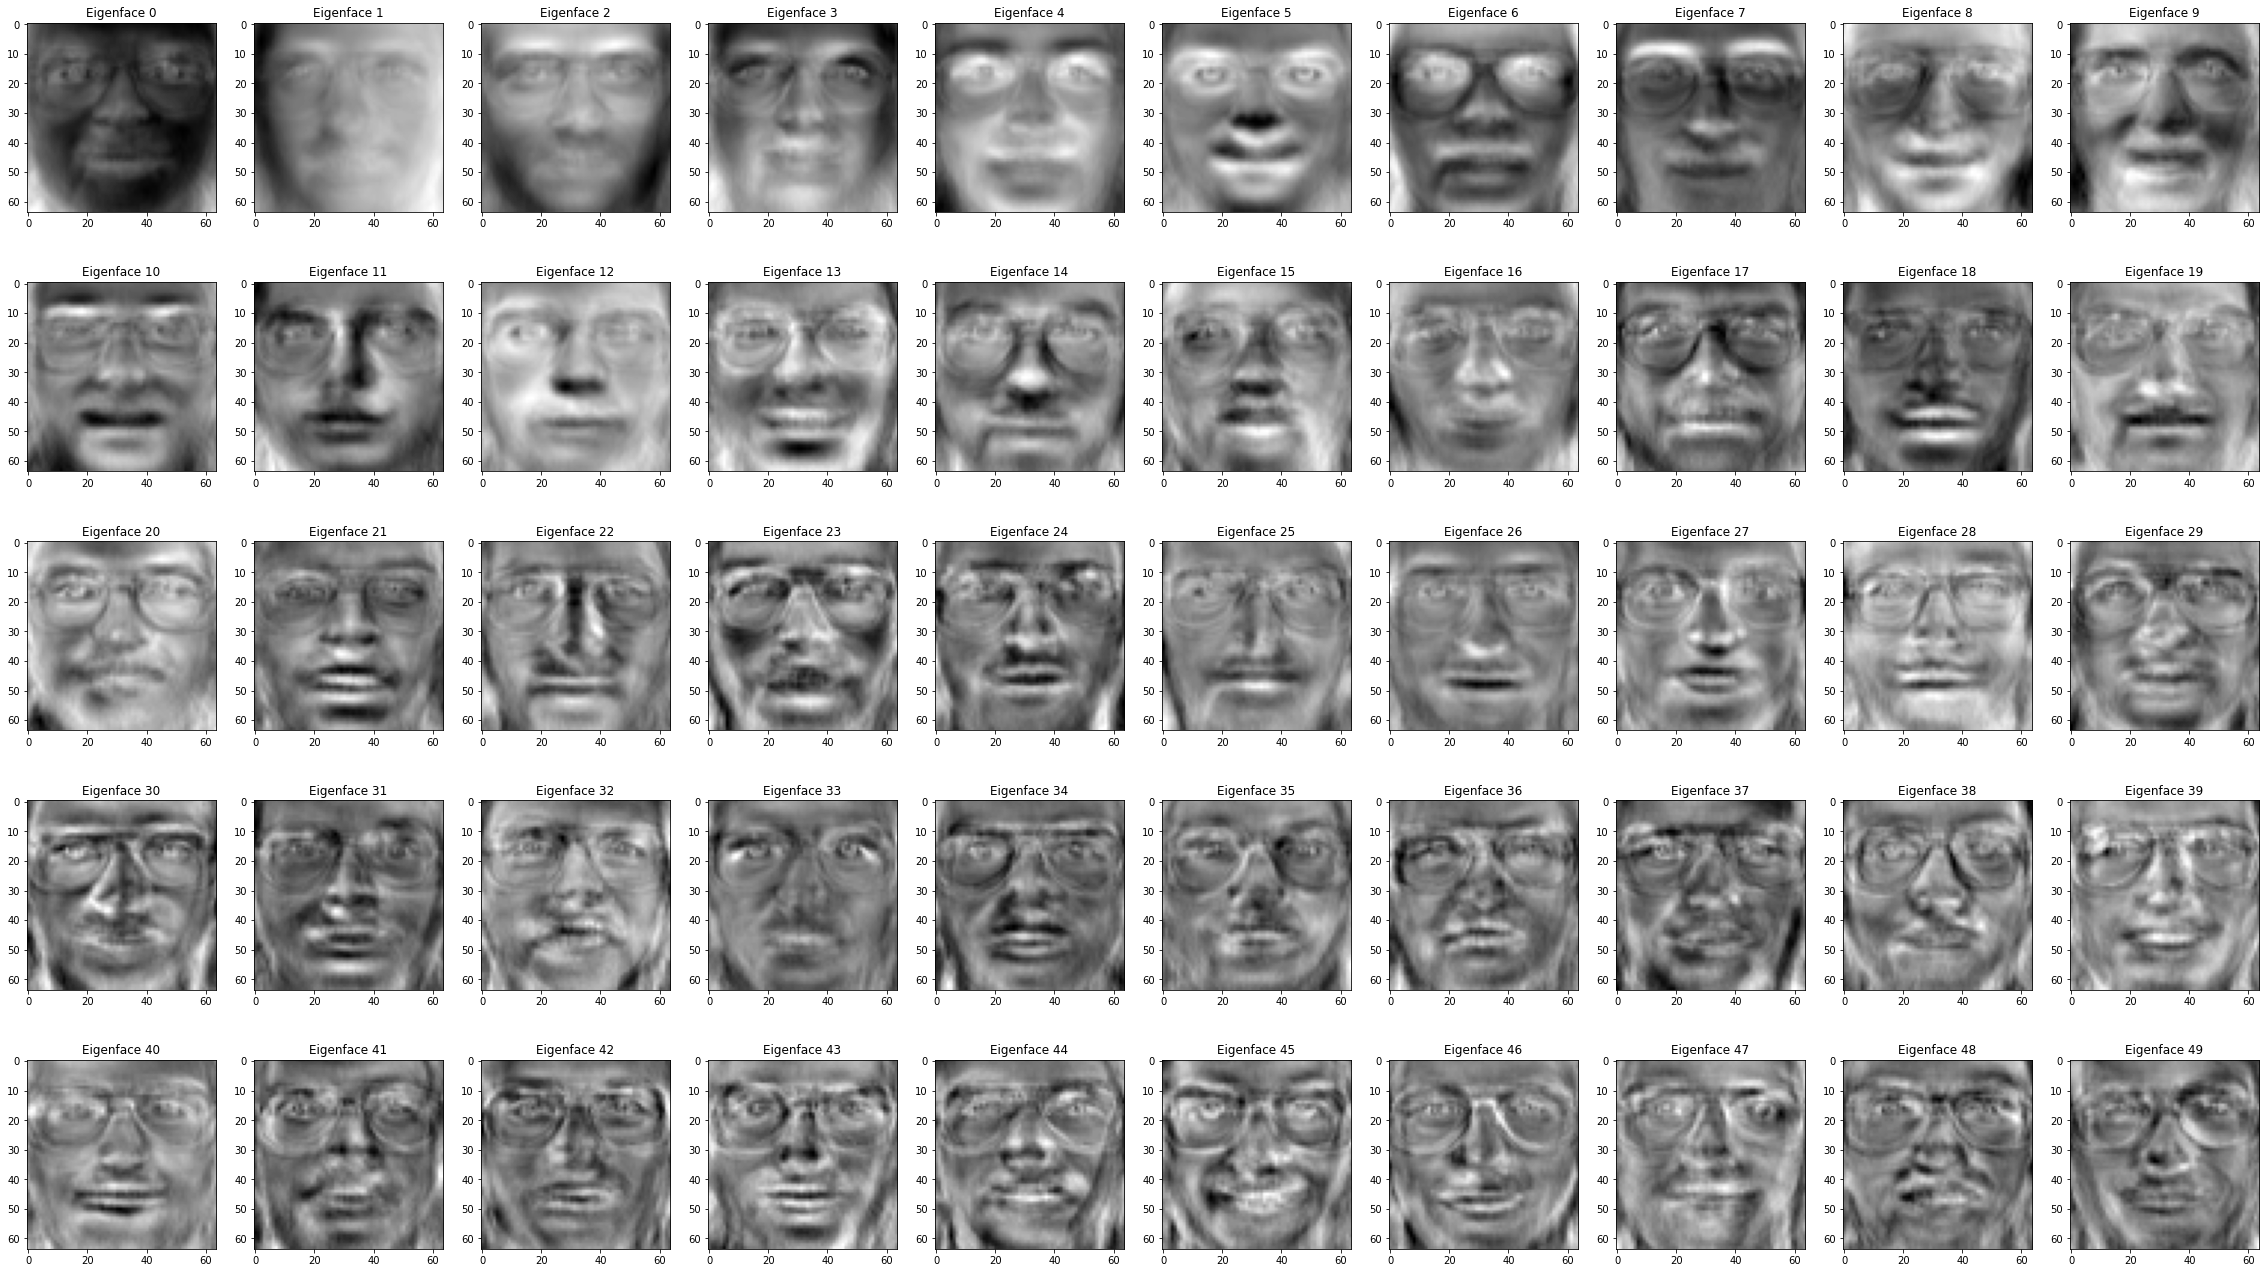

In [6]:


k=50   # Input the value of k to get k eigen faces here
cols = k//5
rows = k//cols
axes=[]
fig=plt.figure(figsize=(4 * cols, 4 * rows))
fig.subplots_adjust(bottom=.01)
for i in range(k):
    axes.append( fig.add_subplot(rows, cols, i+1) )
    subplot_title=("Eigenface "+str(i))
    axes[-1].set_title(subplot_title)  
    plt.imshow(eigenfaces[i].reshape((h, w)), cmap=plt.cm.gray)
   
plt.show()

# Detecting an Image and then recognizing whether it is present in dataset or not.

## Detection of face of the input test image



In [7]:
alpha_1 = 10 # The image will be considered detected if the difference between original and projected face vectors is less than alpha_1
#Chosen threshold for face detection i.e. if beta is less than this than it will return Unknown face.
# My face detection is completely based on alpha_1. This alpha will only help to identify whether face is present or not.
q = 50 
#number of chosen eigenfaces

def face_detection(test_image):
  test_image_1 = np.reshape(test_image, (test_image.size)) - mean_face 
  omega = eigenfaces[:q].dot(test_image_1) #the vector that represents the image with respect to the eigenfaces.
  projected_new_img_vector = eigenfaces[:q].T.dot(omega) #n^2 vector of the new face image represented as the linear combination of the chosen eigenfaces
  difference = test_image_1 - projected_new_img_vector 
  beta = math.sqrt(difference.dot(difference)) #Difference between the original face image vector and the projected vector.
  rows,cols=1,2
  axes=[]
  fig=plt.figure(figsize=(4 * cols, 4 * rows))
  fig.subplots_adjust(bottom=0.01)
  for i in range(2):
    axes.append( fig.add_subplot(rows, cols, i+1) )
    if i==0:
      axes[-1].set_title("Input test image mean subtracted")
      plt.imshow(test_image.reshape((h, w)), cmap=plt.cm.gray)
        
    if i==1:
      axes[-1].set_title("Reconstructed image") 
      plt.imshow(projected_new_img_vector.reshape((h, w)), cmap=plt.cm.gray)
  if beta < alpha_1:
      print("Face detected in the image! The value", beta,"is less than the threshold alpha_1!")
  else:
      print("No face detected in the image! The value", beta,"is greater than the threshold alpha_1!")

Face detected in the image! The value 4.163056749528098 is less than the threshold alpha_1!


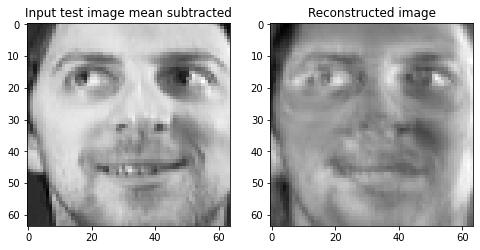

In [8]:
n = random.randint(0, X_test.shape[0])   # Checking on any random image from the test dataset.
face_detection(X_test[n])

No face detected in the image! The value 18.285913706598176 is greater than the threshold alpha_1!


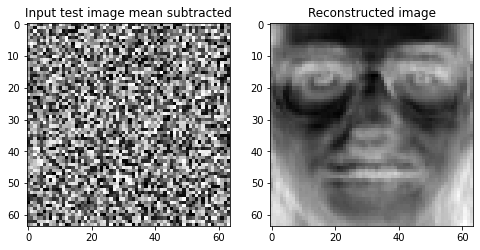

In [9]:
not_face=np.random.rand(1,h*w)     # Checking on any random image, whose pixels are arbitrary numbers.
face_detection(not_face)

## Recognizing the input test image and compairing it with the dataset. Finding Accuracy and Number of occurences.


In [10]:
alpha_2 = 5.5
#This value of alpha_2 is chosen as threshold for this section. 
# Changing the value of alpha_2 will affect the accuracy as well as the number of matches found in the dataset.
# Increasing alpha_2 will increase the accuracy but it will throw some incorrect matches(however the smallest_value match will become more accurate that will increase the accuracy) from the dataset when compared with test image.

def recognize(test_image,X_train):
  index = None #index of the smallest value
  smallest_value = None # It will return the smallest_value of the difference of a given test image with all the images in the dataset.
  all_indexes = []  # Will give the indexes of all the images that match the test image whose difference lies within alpha_2
  test_image_1 = np.reshape(test_image, (test_image.size)) - mean_face 
  omega = eigenfaces[:q].dot(test_image_1) #the vector that represents the image with respect to the eigenfaces.
  total_img = X_train.shape[0]
  for k in range(total_img):
    img = X_train[k]
    img_1 = np.reshape(img, (img.size)) - mean_face 
    omega_k = eigenfaces[:q].dot(img_1) #calculate the vectors of the images in the dataset and represent 
    difference = omega - omega_k
    epsilon_k = math.sqrt(difference.dot(difference)) 
    if smallest_value == None:
      smallest_value = epsilon_k
      index = k
    if epsilon_k < alpha_2:
      all_indexes.append(k)
    if smallest_value > epsilon_k:
      smallest_value = epsilon_k
      index = k
  return index,smallest_value,all_indexes


In [17]:
def accuracy(X_test):
  total=X_test.shape[0]
  count=0
  for i in range(total):
    to_test=X_test[i]
    to_test_label=  y_test[i]
    at_loc,smallest_value, all_indexeses = recognize(to_test,X_train)
    at_loc_label=y_train[at_loc]
    if smallest_value>alpha_2:
      print("Unkown Face!")
    elif at_loc_label==to_test_label and smallest_value<=alpha_2:
      count+=1
      print(i,"actual label=",to_test_label,"|predicted label=",at_loc_label,"|index of predicted label=",at_loc ,"|all matching indexes=", all_indexeses)
    else:
      print(i,"actual label=",to_test_label,"|predicted label=",at_loc_label, "|index of predicted label=",at_loc,"|all matching indexes=",all_indexeses)
  print((count/total)*100)

In [12]:
accuracy(X_test)

0 actual label= 15 |predicted label= 15 |index of predicted label= 216 |all matching indexes= [133, 207, 216]
1 actual label= 19 |predicted label= 19 |index of predicted label= 235 |all matching indexes= [183, 235, 326]
2 actual label= 20 |predicted label= 20 |index of predicted label= 170 |all matching indexes= [170]
3 actual label= 10 |predicted label= 10 |index of predicted label= 46 |all matching indexes= [46]
4 actual label= 34 |predicted label= 34 |index of predicted label= 243 |all matching indexes= [108, 243]
5 actual label= 6 |predicted label= 6 |index of predicted label= 259 |all matching indexes= [259, 285]
6 actual label= 17 |predicted label= 17 |index of predicted label= 334 |all matching indexes= [36, 78, 129, 215, 218, 334]
7 actual label= 22 |predicted label= 22 |index of predicted label= 215 |all matching indexes= [112, 129, 213, 215]
8 actual label= 30 |predicted label= 30 |index of predicted label= 110 |all matching indexes= [59, 110, 196]
9 actual label= 29 |predict

95.0